In [232]:
import hdf5storage
import rat.helpers as helpers
import rat.get_data as get_data
import numpy as np
from bat.helpers_bat import *
from bat.get_data import *


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in the bat data (LFP and positional data)
We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a different file, but luckily the accessors for this were provided by the Yartsev lab (thanks Kevin Qi!).

In [233]:
# Loading bat LFP data
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')

# Check the structure of lfp_mat
print("Structure of lfp_mat:", type(lfp_mat['lfp']), lfp_mat['lfp'].shape)


Structure of lfp_mat: <class 'numpy.ndarray'> (1, 2)


In [234]:
data_path = './bat/data' # Replace this
bat_id = '32622'
date =  '231007'

In [235]:
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

Loading Flight Room | 32622 | 231007 from cache...


In [236]:
pos = session.cortex_data.bat_pos
pos.shape # (num_timepoints, XYZ)

(841160, 3)

Since the position data has a lot of NaNs throughout it, we can interpolate across these spans of NaN values to create a cleaner dataset. More on how this affects the data in ```example.ipynb```.

In [237]:
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

(841160, 3)

## Time synchronization
Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [238]:
lfp_timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds

np.diff(lfp_timestamps.flatten()) #we will see a 400 microsecond difference between each timestamp,
#which means that the sampling rate is 2500 Hz

array([400.00444436, 400.0044446 , 400.00444436, ..., 399.99999905,
       400.        , 400.00000191])

In [239]:
lfp_timestamps.shape

(17222917, 1)

Above, we filtered out the negative timestamps from the position recording relative to the global timestamp start. We simply had to filter out the corresponding samples in position to synchronize. Now we're ready to make timebins from the LFP timestamp data and bin the positional data accordingly.

In [240]:
from scipy.signal import decimate
lfp_timestamps_dec = decimate(lfp_timestamps.flatten(), 100) #decimate from 2500 Hz to 25 Hz (100x decimation)
lfp_timestamps_dec.shape
#lfp_timestamps_dec[0:10]

(172230,)

Now that we downsampled the LFP timestamps, we will lop off negative timestamps to ensure that we have proper "edges" between bins (more on this later).

In [241]:
lfp_indices = lfp_timestamps_dec > 0 # lop off negative timestamps on LFP timestamps; we will use this to refit the LFP data later.
lfp_timestamps_dec = lfp_timestamps_dec[lfp_indices] 
lfp_timestamps_edges = np.insert(lfp_timestamps_dec, 0, 0) # insert 0 at the beginning

lfp_timestamps_edges.shape
lfp_timestamps_edges[0:10]

array([     0.        ,   4514.44262606,  44057.00577409,  83599.56892214,
       123142.1320702 , 162684.69521825, 202227.25836628, 241769.82151429,
       281312.3846624 , 320854.94781046])

We now have our decimated LFP timebins. Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average out points between edges of the LFP timebins to get synchronized data streams.

In [242]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
np.diff(pos_timestamps) #we will see an average of a 8333 microsecond difference between each timestamp, meaning that the sampling rate is around 120 Hz

array([8333.33333331, 8333.33333334, 8333.33333334, ..., 8333.33772278,
       8333.33771515, 8333.33771515])

In [243]:
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions
cleaned_pos.shape

(824435, 3)

In [244]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

# Construct the array according to its columns
binned_pos = np.column_stack((binned_pos_x, binned_pos_y, binned_pos_z))

In [245]:
# Verify the results
print("Binned position shape:", binned_pos.shape)
print("LFP timestamp edges shape:", lfp_timestamps_edges.shape)

print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

Binned position shape: (170690, 3)
LFP timestamp edges shape: (170691,)
First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35497956 -1.70192085  0.01016301]
 [-1.35496366 -1.70190326  0.01020436]
 ...
 [-1.24507387 -1.627617    0.04300965]
 [-1.24505479 -1.62760721  0.0430833 ]
 [        nan         nan         nan]]
First few LFP bins: [     0.           4514.44262606  44057.00577409  83599.56892214
 123142.1320702 ]


Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

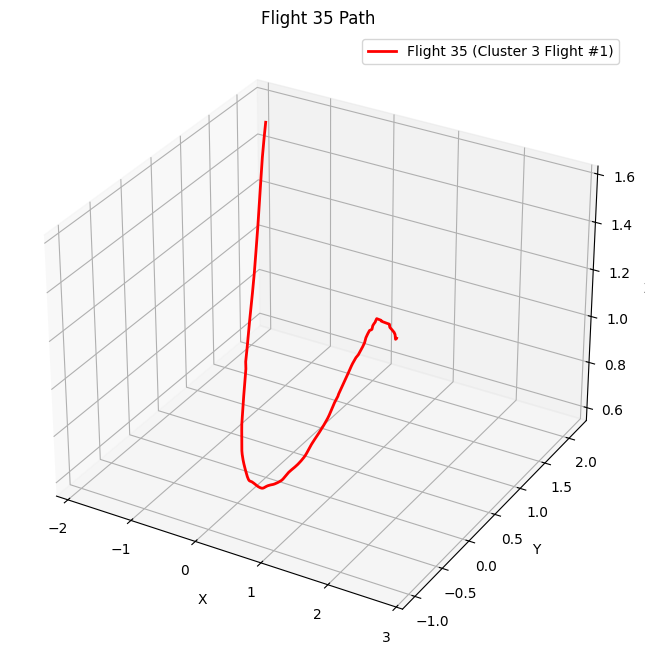

In [246]:
from bat.get_data import get_cluster_labels, get_flight_boolean_array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.colors as mcolors

clutser_2_labels = get_cluster_labels(session, 2)

# Get boolean array for the 35th flight overall (which might be in cluster 3)
flight_35_bool, flight_35_cluster = get_flight_boolean_array(session, 35)

# Create a new figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the boolean array for indexing or plotting
ax.plot(pos[flight_35_bool, 0], pos[flight_35_bool, 1], pos[flight_35_bool, 2],
        color='red', linewidth=2, label=f'Flight 35 (Cluster 3 Flight #1)')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Flight 35 Path')

# Add legend
ax.legend()

# Show the plot
plt.show()

We are creating labels (timebin_labels) to associate which timebins are related to which flight so we can access them accordingly.

In [247]:
labels = flight_35_bool[valid_indices] # we can also do this by cluster : labels = cluster_2_labels[valid_indices]
labels.shape

(824435,)

In [248]:
timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
timebin_labels.shape

(170690,)

In [249]:
print(len(binned_pos[0]), len(binned_pos[1]), len(timebin_labels))

3 3 170690


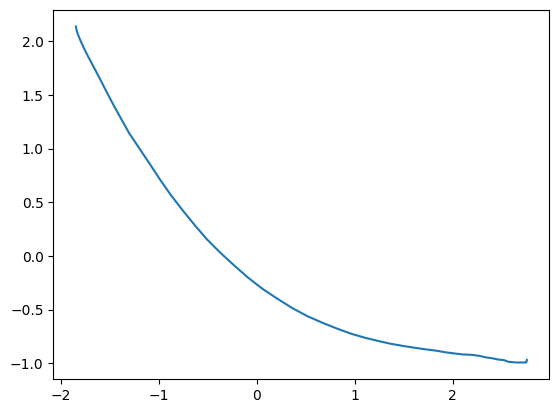

In [250]:
plt.plot(binned_pos[:, 0][:len(timebin_labels)][timebin_labels > 0], 
         binned_pos[:, 1][:len(timebin_labels)][timebin_labels > 0])

Using timebin_labels, we can filter out the binned position data for each flight. This will allow us to organize flight data later.

### Organizing behavioral data
To better organize the binned flight data, we need to construct a flightID array which will contain all the binned positions for each flight, accounting for which feeder (or the perch) was visited for each data point entered in that flight.

In [264]:
from bat.get_data import determine_feeder
def get_flight_boolean_array(session, global_flight_number, off_samples=0):
    """
    Generate a boolean array for a specific flight across all clusters and return its cluster ID
    and phase labels (pre, in, post flight).

    Input:
    - session: A session object containing flight data and cluster information.
    - global_flight_number: An integer representing the overall flight number to retrieve,
      counting sequentially across all clusters (excluding cluster 1).
    - off_samples: Number of samples to include before and after the flight.

    Output:
    - boolean_array: A numpy array of booleans, where True indicates the timebins
      corresponding to the specified flight.
    - phase_labels: A numpy array with values indicating phase: 0 for pre-flight,
      1 for in-flight, and 2 for post-flight.
    - cluster_id: An integer representing the cluster ID of the specified flight.

    Raises:
    - ValueError: If the global_flight_number is invalid (i.e., higher than the total
      number of flights across all clusters).

    Note:
    - Cluster 1 is excluded from the count.
    - Flights are counted sequentially across clusters in ascending order of cluster IDs.
    """
    flight_behavior = session.cortex_data
    boolean_array = np.zeros(flight_behavior.num_cortex_timebins, dtype=bool)
    phase_labels = np.full(flight_behavior.num_cortex_timebins, -1, dtype=int)  # Initialize with -1 for unused samples
    
    all_clusters = sorted([int(cluster_id) for cluster_id in session.flights_by_cluster.keys() if int(cluster_id) != 1])
    
    flight_count = 0
    for cluster_id in all_clusters:
        cluster_flights = session.get_flights_by_cluster([cluster_id])
        for flight in cluster_flights:
            flight_count += 1
            if flight_count == global_flight_number:
                start_idx, end_idx = flight.timebin_start_idx, flight.timebin_end_idx
                pre_start_idx = max(start_idx - off_samples, 0)
                post_end_idx = min(end_idx + off_samples, flight_behavior.num_cortex_timebins)
                boolean_array[pre_start_idx:post_end_idx] = True

                # Set phase labels
                if off_samples > 0:
                    phase_labels[pre_start_idx:start_idx] = 0  # pre-flight
                    phase_labels[start_idx:end_idx] = 1  # in-flight
                    phase_labels[end_idx:post_end_idx] = 2  # post-flight
                else:
                    phase_labels[start_idx:end_idx] = 1  # in-flight

                return boolean_array, phase_labels, cluster_id
    
    raise ValueError(f"Invalid flight number. Must be between 1 and {flight_count}")

def get_flightID(session, binned_pos, valid_indices, lfp_timestamps_decimated_bins, pos_timestamps, off_samples=0):
    """
    Construct a flightID array for all flights in the session.
    Input:
    - session: A session object containing flight data and cluster information.
    - binned_pos: A numpy array of pre-filtered binned position data with shape (num_timebins, 3).
    - valid_indices: Array of valid indices to use for the binned position data.
    - lfp_timestamps_decimated_bins: Timestamps for the LFP bins.
    - pos_timestamps: Timestamps for the position data.
    - off_samples: Number of samples to include before and after each flight.
    Output:
        flightID = Data stored in the format listed below
    flightID format:
        Column 0: Flight Number
        Column 1: Feeder visited (0: perch, 1: feeder 1, 2: feeder 2)
        Column 2: X position in M
        Column 3: Y position in M
        Column 4: Z position in M
        Column 5: Flight phase (0: pre-flight, 1: in-flight, 2: post-flight)
    """
    all_flight_data = []
    flight_count = 0

    all_clusters = sorted([int(cluster_id) for cluster_id in session.flights_by_cluster.keys() if int(cluster_id) != 1])

    for cluster_id in all_clusters:
        cluster_flights = session.get_flights_by_cluster([cluster_id])
        for flight in cluster_flights:
            flight_count += 1
            flight_bool, phase_labels, _ = get_flight_boolean_array(session, flight_count, off_samples)
            
            # Apply valid_indices to the flight boolean array
            labels = flight_bool[valid_indices]
            
            # Label timebins for this flight
            timebin_labels = label_timebins(lfp_timestamps_decimated_bins, labels, pos_timestamps, is_discrete=True)
            
            # Get binned position data for this flight
            flight_pos = binned_pos[timebin_labels > 0]

            if flight_pos.shape[0] == 0:
                continue  # Skip this flight if no valid positions are found

            # Determine feeder visited based on end position
            end_pos = flight_pos[-1]
            feeder = determine_feeder(end_pos)

            # Get flight phases for the valid timebin labels
            flight_phases = phase_labels

            # Create flight data for all timebins of this flight
            flight_data = np.column_stack((
                np.full(flight_pos.shape[0], flight_count),
                np.full(flight_pos.shape[0], feeder),
                flight_pos[:, 0],  # X positions
                flight_pos[:, 1],  # Y positions
                flight_pos[:, 2],  # Z positions,
                flight_phases
            ))

            all_flight_data.append(flight_data)

    # Concatenate all flight data
    flightID = np.vstack(all_flight_data) if all_flight_data else np.array([])

    return flightID

flightID = get_flightID(session, binned_pos, valid_indices, lfp_timestamps_edges, pos_timestamps, off_samples = 125) #includes the 5 seconds before and after flight

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 155 and the array at index 5 has size 841160

In [257]:
flightID.shape

(11480, 5)

In [ ]:
flightID[1:]

array([[ 1.        ,  1.        ,  2.40218066,  0.62000732,  1.61959424],
       [ 1.        ,  1.        ,  2.40218066,  0.62000732,  1.61959424],
       [ 1.        ,  1.        ,  2.40218066,  0.62000732,  1.61959424],
       ...,
       [78.        ,  0.        , -1.68463416,  2.03203082,  1.68743652],
       [78.        ,  0.        , -1.68463416,  2.03203082,  1.68743652],
       [78.        ,  0.        , -1.68463416,  2.03203082,  1.68743652]])

## LFP extraction and downsampling

In [ ]:
# Extract subarrays and check their structure
lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]

print(f"Type of lfp_data_1: {type(lfp_data_1)}, Shape of lfp_data_1: {lfp_data_1.shape}")
print(f"Type of lfp_data_2: {type(lfp_data_2)}, Shape of lfp_data_2: {lfp_data_2.shape}")

n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)


Type of lfp_data_1: <class 'numpy.ndarray'>, Shape of lfp_data_1: (192, 17222917)
Type of lfp_data_2: <class 'numpy.ndarray'>, Shape of lfp_data_2: (192, 17222917)


We have the raw MATLAB data field stored in `lfp_data_1` and `lfp_data_2`, but in order to actually work with this data, we need to deserialize it into an array we can index. To do this, I've supplied `helpers.py/get_LFP_from_mat`, which will *import and automatically decimate the data*. 

In [ ]:
from rat.get_data import get_LFP_from_mat
# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_LFP_from_mat(lfp_data_1,n_channels,2500,use_cache=True) #in order to change decimation, change fs=25 to desired sampling rate
lfp_bat_2 = get_LFP_from_mat(lfp_data_2,n_channels,2500,use_cache=True)

lfp_bat_combined = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1) # ALREADY DECIMATED TO 25 Hz


In [ ]:
print("lfp_bat_1 shape:", lfp_bat_1.shape) # (n_samples, n_channels)
print("lfp_bat_2 shape:", lfp_bat_2.shape) # (n_samples, n_channels)
print("lfp_bat_combined shape:", lfp_bat_combined.shape) # (n_samples, 2*n_channels)

lfp_bat_1 shape: (172230, 192)
lfp_bat_2 shape: (172230, 192)
lfp_bat_combined shape: (172230, 384)


Once LFP is loaded in and downsampled, we can apply a bandpass and Hilbert transform to get our complex-valud LFP!

In [ ]:
LFPs = helpers.filter_data(lfp_bat_combined, [4, 12], fs=25, filt_type='band', use_hilbert=True) #bandapss filter between 4 and 12 Hz (theta band)
LFPs.shape

(172230, 384)

In [ ]:
LFPs = LFPs[lfp_indices]
LFPs.shape


(170690, 384)

We now have our processed LFP. Now we need trim this to get our 

In [ ]:
from bat.get_data import get_flightLFP

tLFP = get_flightLFP(session, LFPs, valid_indices, lfp_timestamps_edges, pos_timestamps)

In [ ]:
tLFP.shape

(7376, 385)

/Users/tenboker/Desktop/Code Shtuff/FRITZ/yartsev/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tenboker/Desktop/Code Shtuff/FRITZ/yartsev/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


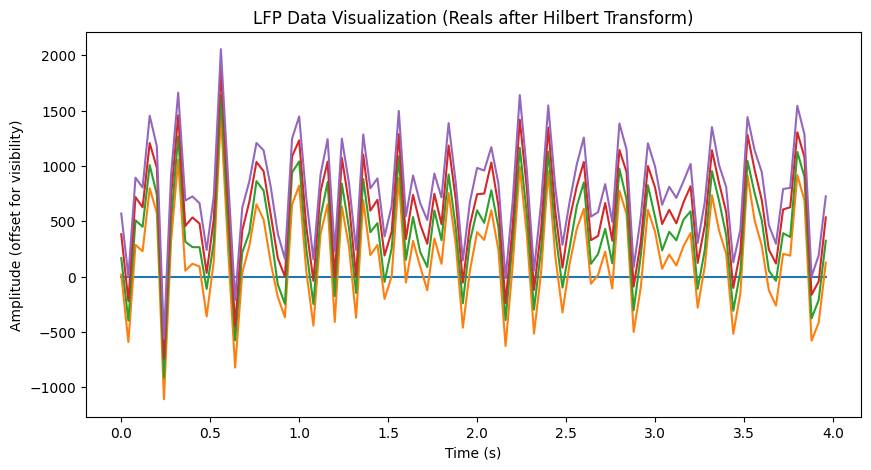

In [ ]:
from bat.synchrony import plot_raw_lfp

# Example usage
plot_raw_lfp(tLFP, n_channels=5, start_time=0, end_time=100)


## Testing synchrony

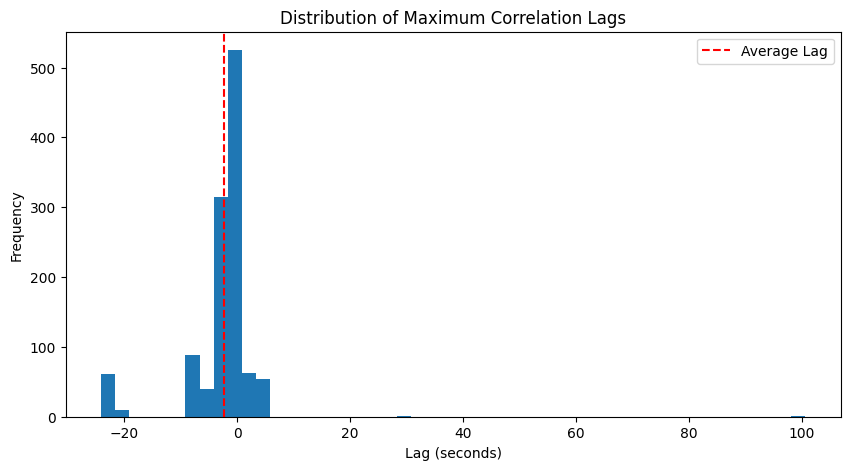

Average maximum correlation lag: -2.408096 seconds
Standard deviation of lags: 6.690275 seconds


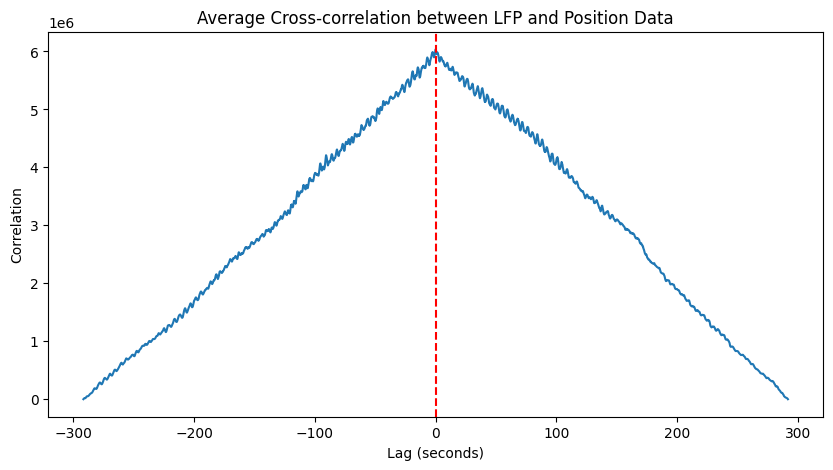

In [ ]:
from bat.synchrony import test_synchronization

# Example usage
test_synchronization(tLFP, flightID[:, -3:], lfp_timestamps_dec)

/var/folders/zx/1lpjp2mx28scvgwy0hybb3g00000gn/T/ipykernel_84831/3335171689.py:39: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  freqs, times, power = signal.spectrogram(np.mean(flight_data, axis=1), fs=sampling_rate)
/var/folders/zx/1lpjp2mx28scvgwy0hybb3g00000gn/T/ipykernel_84831/3335171689.py:39: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, times, power = signal.spectrogram(np.mean(flight_data, axis=1), fs=sampling_rate)


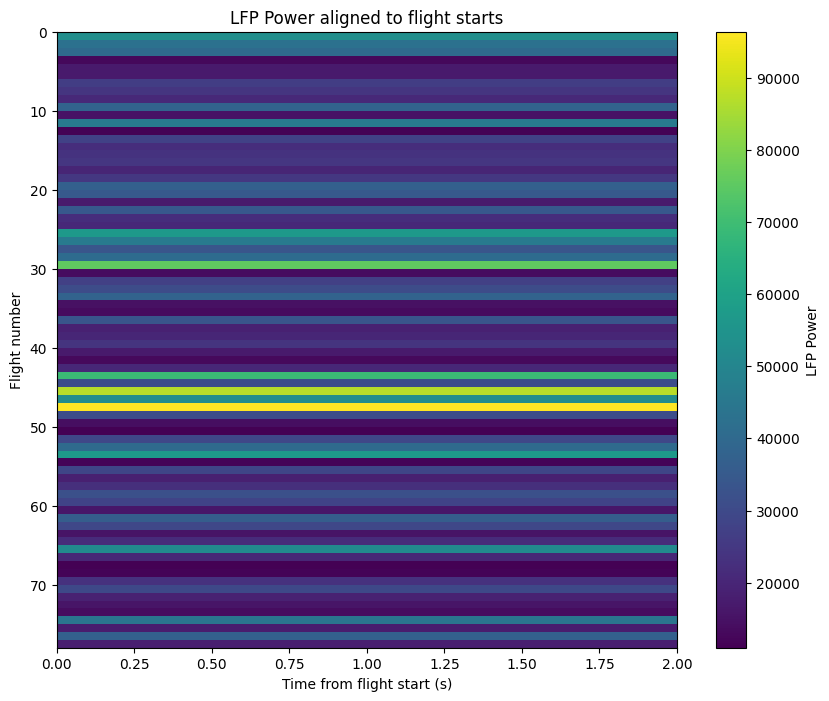

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# Assuming you have these variables:
# session: your session object
# LFPs: your LFP data
# valid_indices: valid indices for your data
# lfp_timestamps_decimated_bins: timestamps for LFP bins
# pos_timestamps: timestamps for position data
# sampling_rate: sampling rate of your LFP data (25 Hz as mentioned)

sampling_rate = 25

# Get flightLFP data
flightLFP = tLFP

# Parameters
num_flights = len(np.unique(flightLFP[:, 0]))  # Number of unique flights
max_flight_duration = 2  # seconds, adjust as needed
time_bins = np.linspace(0, max_flight_duration, int(max_flight_duration * sampling_rate))

# Create a 2D array to store power for each flight and time point
power_array = np.zeros((num_flights, len(time_bins)))

# Calculate power for each flight
for flight_num in range(1, num_flights + 1):
    flight_data = flightLFP[flightLFP[:, 0] == flight_num, 1:]  # LFP data for this flight
    
    if len(flight_data) == 0:
        continue
    
    # Pad or truncate the flight data to match max_flight_duration
    if len(flight_data) < len(time_bins):
        flight_data = np.pad(flight_data, ((0, len(time_bins) - len(flight_data)), (0, 0)), mode='constant')
    else:
        flight_data = flight_data[:len(time_bins)]
    
    # Calculate power (you might want to use a more sophisticated method)
    freqs, times, power = signal.spectrogram(np.mean(flight_data, axis=1), fs=sampling_rate)
    
    # Average power across frequencies
    avg_power = np.mean(power, axis=0)
    
    # Store in the array
    power_array[flight_num - 1, :] = avg_power[:len(time_bins)]

# Create the heat map
plt.figure(figsize=(10, 8))
plt.imshow(power_array, aspect='auto', cmap='viridis', 
           extent=[0, max_flight_duration, num_flights, 0])
plt.colorbar(label='LFP Power')
plt.xlabel('Time from flight start (s)')
plt.ylabel('Flight number')
plt.title('LFP Power aligned to flight starts')
plt.show()

# Applying TIMBRE


Initial train_inds (before balancing): 305
actual_indices length: 305
unique_elements: [0. 1. 2.]
elements_indices: {0.0: [4458, 4459, 4460, 4461, 4462, 4520, 4521, 4522, 4523, 4524, 4581, 4582, 4583, 4584, 4585, 4644, 4645, 4646, 4647, 4648, 4768, 4769, 4770, 4771, 4772, 4826, 4827, 4828, 4829, 4830, 7237, 7238, 7239, 7240, 7241, 7302, 7303, 7304, 7305, 7306], 1.0: [198, 199, 200, 201, 202, 301, 302, 303, 304, 305, 406, 407, 408, 409, 410, 510, 511, 512, 513, 514, 723, 724, 725, 726, 727, 836, 837, 838, 839, 840, 940, 941, 942, 943, 944, 1046, 1047, 1048, 1049, 1050, 1252, 1253, 1254, 1255, 1256, 1356, 1357, 1358, 1359, 1360, 1453, 1454, 1455, 1456, 1457, 1563, 1564, 1565, 1566, 1567, 1768, 1769, 1770, 1771, 1772, 1872, 1873, 1874, 1875, 1876, 1975, 1976, 1977, 1978, 1979, 2078, 2079, 2080, 2081, 2082, 2285, 2286, 2287, 2288, 2289, 2388, 2389, 2390, 2391, 2392, 2491, 2492, 2493, 2494, 2495, 2593, 2594, 2595, 2596, 2597, 2806, 2807, 2808, 2809, 2810, 2913, 2914, 2915, 2916, 2917, 3018,

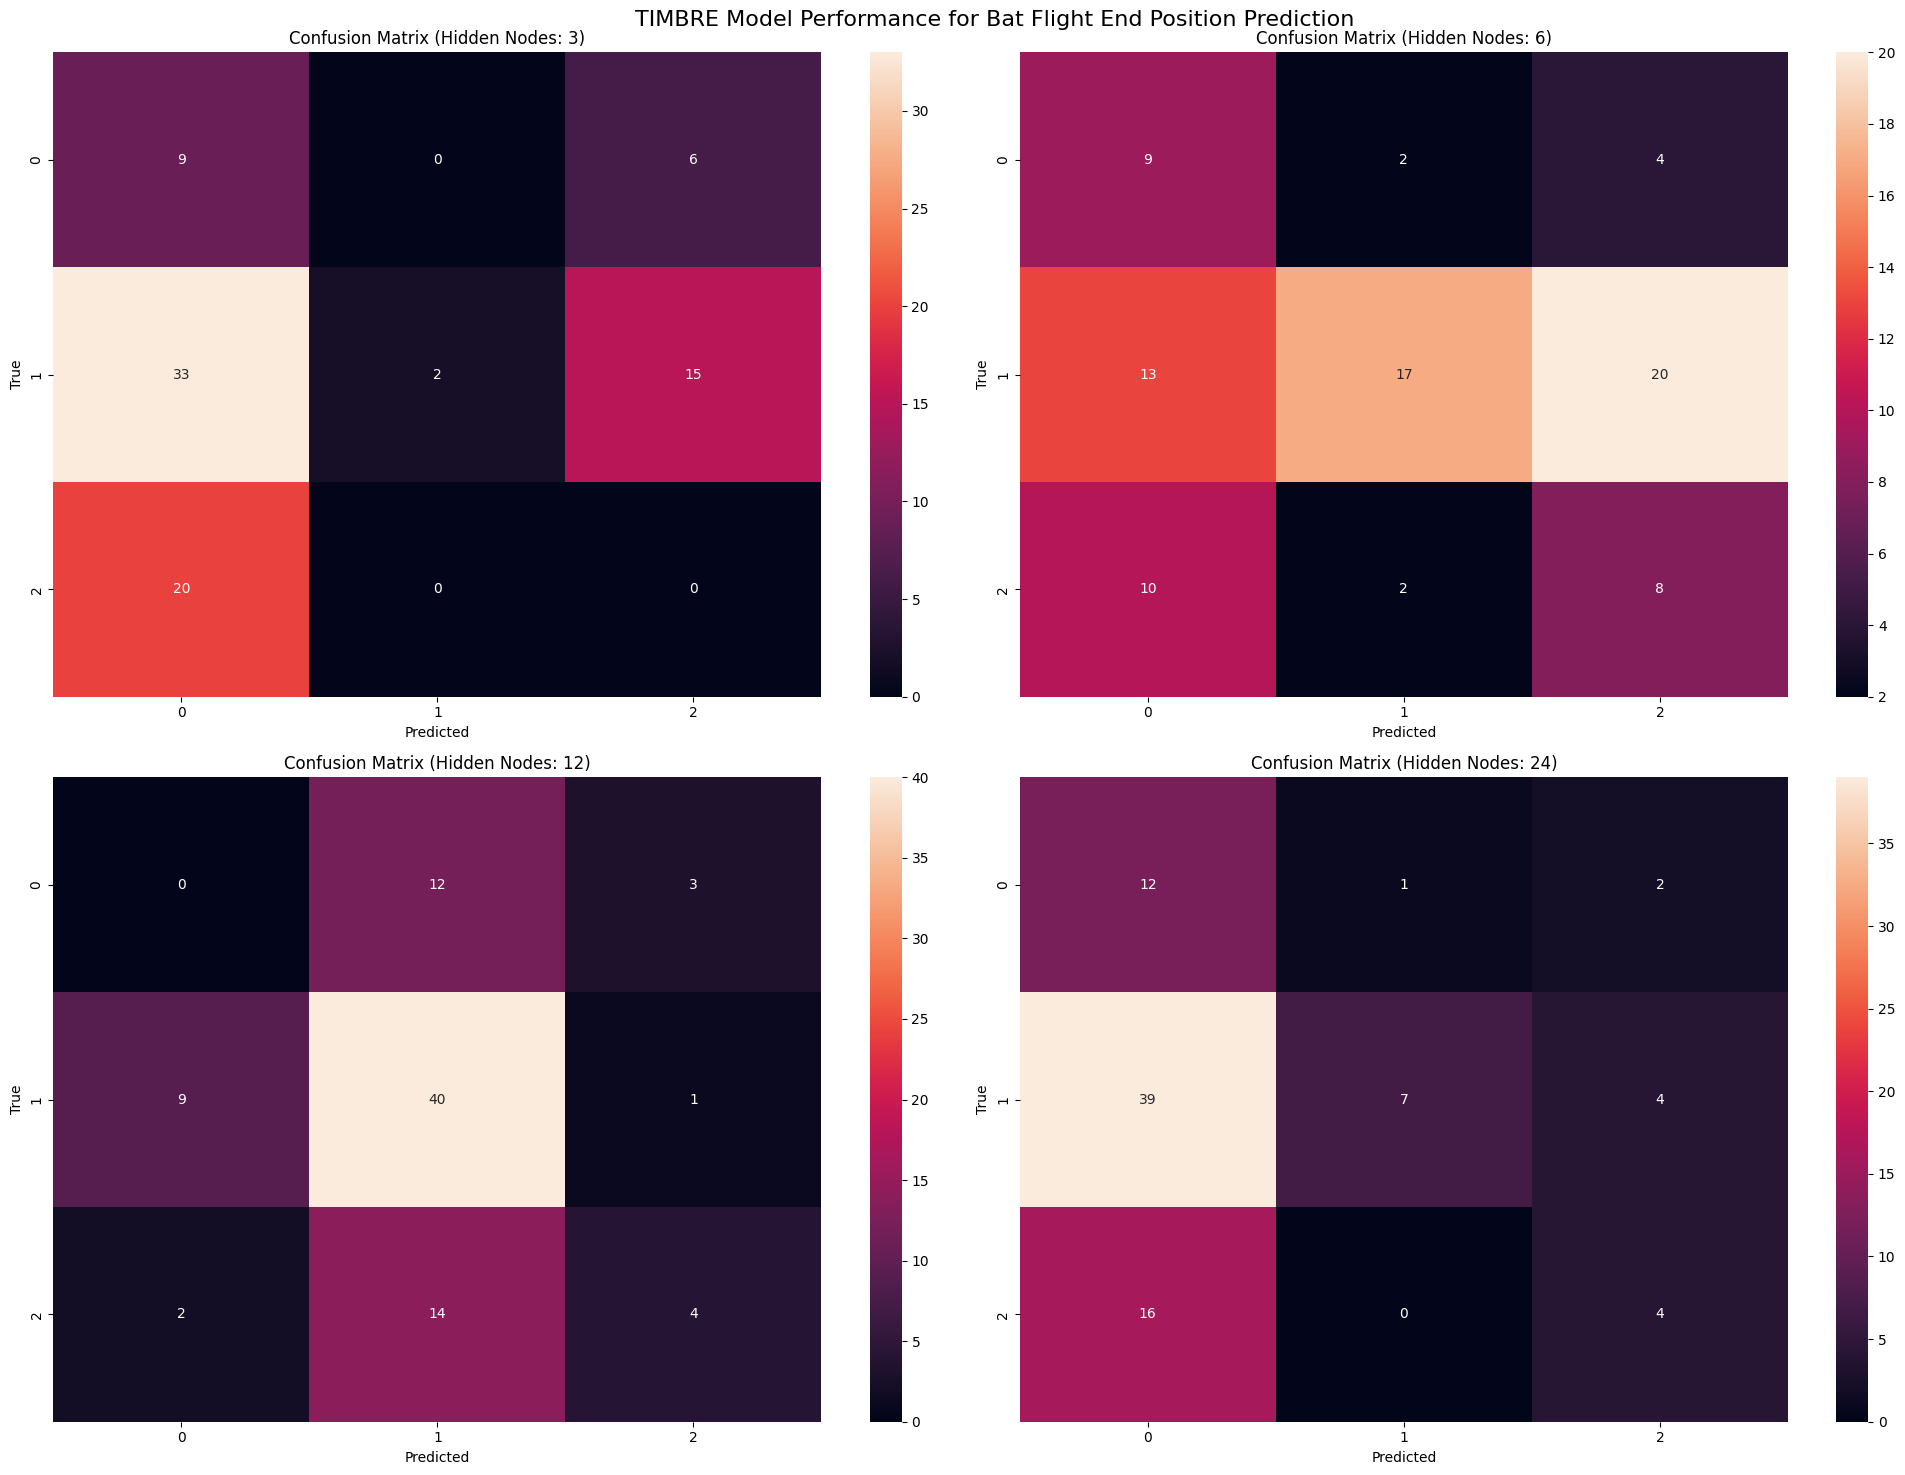

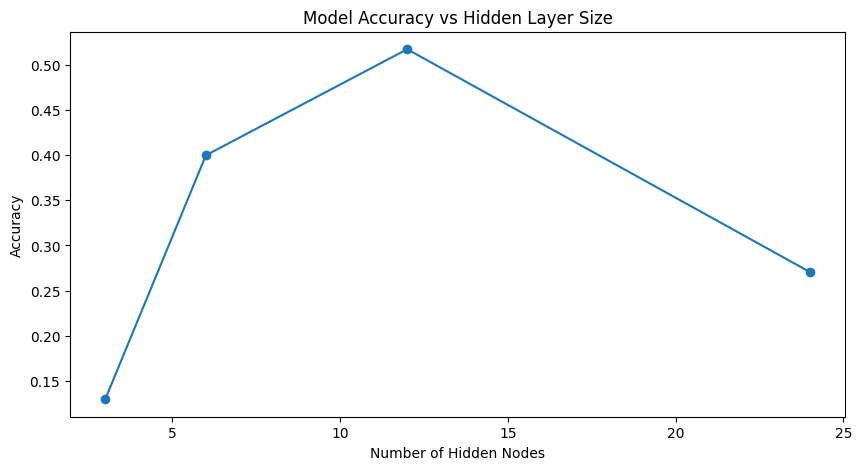

In [ ]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('TIMBRE Model Performance for Bat Flight End Position Prediction', fontsize=16)

n_folds = 5
which_fold = 0

test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)
wLFPs, _, _ = helpers.whiten(tLFP, train_inds)

accuracies = []
hidden_sizes = [3, 6, 12, 24]

for i, hidden_size in enumerate(hidden_sizes):
    print(f"Training network with {hidden_size} hidden nodes")
    m, _, _ = TIMBRE(wLFPs, flightID[:, 1], test_inds, train_inds, hidden_nodes=hidden_size, is_categorical=True)
    
    # Get predictions
    output_layer = helpers.layer_output(wLFPs[test_inds], m, -1)
    predictions = np.argmax(output_layer, axis=1)
    true_labels = flightID[test_inds, 1]
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    accuracies.append(accuracy)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Confusion Matrix (Hidden Nodes: {hidden_size})')
    axs[i//2, i%2].set_xlabel('Predicted')
    axs[i//2, i%2].set_ylabel('True')

plt.tight_layout()
plt.show()

# Plot accuracy vs model complexity
plt.figure(figsize=(10, 5))
plt.plot(hidden_sizes, accuracies, marker='o')
plt.title('Model Accuracy vs Hidden Layer Size')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Accuracy')
plt.show()